# Different Powertrains example

In this example, we'll showcase how you can run different powertrain technologies.

This builds off of the [Open Street Maps Example](open_street_maps_example) and assumes that we've already downloaded a road network so be sure to check that one out first.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

from nrel.routee.compass import CompassApp
from nrel.routee.compass.plot import plot_route_folium, plot_routes_folium
from nrel.routee.compass.io.convert_results import results_to_geopandas

## Running

### Load Application

Here, we'll load our application from the config file that was built in the [Open Street Maps Example](open_street_maps_example)

In [2]:
app = CompassApp.from_config_file("denver_co/osm_default_energy.toml")

edge LineString geometry file: 100%|██████████| 48393/48393 [00:00<00:00, 1160741.38it/s]


## Queries

RouteE Compass can execute search plans for internal combustion (ICE), plug-in hybrid (PHEV) and battery electric (BEV) powertrain types. 
Each of these powertrain types are represented by RouteE Powertrain models.
To see all the models we can use you can take a look at the folder `denver_co/models` and then reference the `traversal.vehicles` section of the `osm_default_energy.toml` configuration file to see how they are integrated and what name is expected as the `model_name` parameter in the query.
Note that you can also train your own RouteE Powertrain models.
Take a look at [this notebook](https://github.com/NREL/routee-powertrain/blob/main/docs/model_training-smartcore.ipynb) for more details.

To demonstrate running other powertrain types, we'll use an ICE (2016_TOYOTA_Camry_4cyl_2WD), a BEV (2017_CHEVROLET_Bolt) and a PHEV (2016_CHEVROLET_Volt) model and create queries for each powertrain type.

Notice that we can specify the `starting_soc_percent` for any vehicle that uses electric energy (BEV and PHEV).
Also notice that we specify the energy weights for both "electric" and "liquid" energy that get applied to both energy sources.
In the cases of the ICE and BEV, we only use one type of energy (liquid and electric respectively). 
But, for the PHEV model, we use a combination of liquid and electric energy.
By default, the PHEV will run using battery energy exclusively (starting at `starting_soc_percent`) and when the battery runs out, the vehicle will switch to it's hybrid mode, using primarily gasoline energy.

In [42]:
query = [
    {
        "origin_x": -104.969307,
        "origin_y": 39.779021,
        "destination_x": -104.975360,
        "destination_y": 39.693005,
        "starting_soc_percent": 100,
        "vehicle_rates": {
            "distance": {"type": "factor", "factor": 0.655},
            "time": {"type": "factor", "factor": 0.33},
            "energy_electric": {"type": "factor", "factor": 0.5},
            "energy_liquid": {"type": "factor", "factor": 3.1}, 
        },
        "grid_search": {
            "model_name": ["2017_CHEVROLET_Bolt", "2016_TOYOTA_Camry_4cyl_2WD", "2016_CHEVROLET_Volt"],
            "test_cases": [
                {
                    "name": "least_time",
                    "weights": {"distance": 0, "time": 1, "energy_electric": 0, "energy_liquid": 0},
                },
                {
                    "name": "least_energy",
                    "weights": {"distance": 0, "time": 0, "energy_electric": 1, "energy_liquid": 1},
                },
            ]
        },
    },
]

In [43]:
result = app.run(query)

search: 100%|██████████| 6/6 [00:00<00:00, 104.11it/s]286.88it/s]]


First, let's review the state model to see what energy units we're using.

In [44]:
result[0]["route"]["state_model"]

{'energy_electric': {'energy_unit': 'kilowatt_hours',
  'initial': 0.0,
  'index': 0,
  'name': 'energy_electric'},
 'battery_state': {'type': 'soc',
  'unit': 'percent',
  'format': {'floating_point': {'initial': 100.0}},
  'index': 1,
  'name': 'battery_state'},
 'time': {'time_unit': 'minutes', 'initial': 0.0, 'index': 2, 'name': 'time'},
 'distance': {'distance_unit': 'miles',
  'initial': 0.0,
  'index': 3,
  'name': 'distance'}}

Now we can take a look at the results.
First let's convert the results into a dataframe

In [45]:
gdf = results_to_geopandas(result)

Let's convert all the energy types to be in a single unit.
We'll use gge as our unit and convert the electrical energy using a factor of 33.694 kwh/gge

In [46]:
gdf["gge"] = (gdf["route.traversal_summary.energy_electric"].fillna(0) * (1/33.694)) + gdf["route.traversal_summary.energy_liquid"].fillna(0)

Next, we can look at the energy usage versus the route time, broken out by powertrain and route objective

<Axes: xlabel='route.traversal_summary.time', ylabel='gge'>

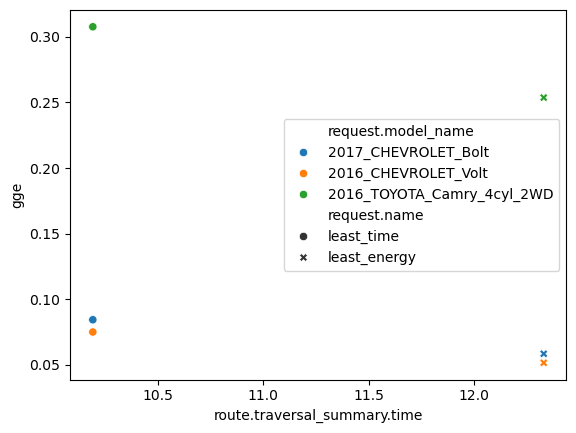

In [47]:
sns.scatterplot(gdf, x="route.traversal_summary.time", y="gge", hue="request.model_name", style="request.name")

Here, we see that the BEV and the PHEV use much less energy than the ICE alternative but all powertrains have a route that uses less energy and more time.

We could also look at the estimated cost based on our assumptions of:

 - distance: \\$ 0.655 per mile
 - time: \\$ 0.33 per minute (\\$ 20 per hour)
 - gasoline: \\$ 3.1 per gallon
 - electric: \\$ 0.5 per kilowatt-hour


<Axes: xlabel='route.traversal_summary.time', ylabel='route.cost.total_cost'>

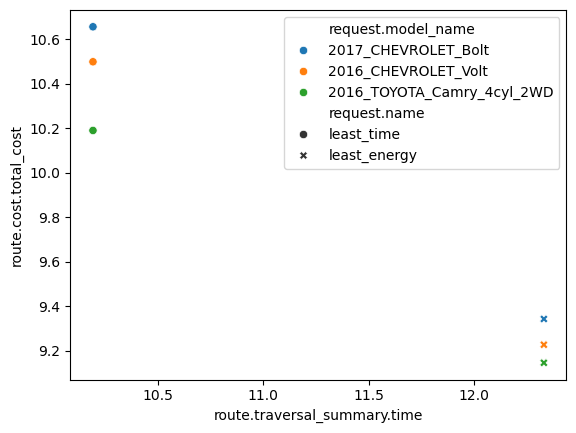

In [48]:
sns.scatterplot(data=gdf, y="route.cost.total_cost", x="route.traversal_summary.time", hue="request.model_name", style="request.name")

Here, we notice that the ICE vehicle has the lowest costs and all powertrains save money on the optimal energy route.
This would likely change based on our cost assumptions (for example if we assume that charging is done at home for a much lower cost of electricity)

Lastly, we can plot the results

<Axes: >

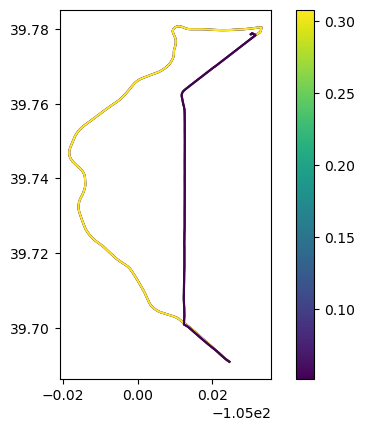

In [56]:
gdf.plot(column="gge", legend=True)